In [2]:
import datetime
import json
import math
import os

from absl import app
from absl import flags

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from open_spiel.python.utils import gfile

X_AXIS = {
    "step": "step",
    "time": "time_rel_h",
    "states": "total_states",
}

In [3]:
os.listdir('../az/pt/c4_1/')

['config.json', 'learner.jsonl']

In [135]:
MAX_WIDTH = int(os.getenv("COLUMNS", "200"))  # Get your TTY width.
SMOOTHING_RATE = 10
SUBSAMPLING_MAX = 250

In [136]:
def print_columns(strings, max_width=MAX_WIDTH):
  """Prints a list of strings in columns."""
  padding = 2
  shortest = min(len(s) for s in strings)
  max_columns = max(1, math.floor((max_width - 1) / (shortest + 2 * padding)))
  for cols in range(max_columns, 0, -1):
    rows = math.ceil(len(strings) / cols)
    chunks = [strings[i:i + rows] for i in range(0, len(strings), rows)]
    col_widths = [max(len(s) for s in chunk) for chunk in chunks]
    if sum(col_widths) + 2 * padding * len(col_widths) <= max_width:
      break
  for r in range(rows):
    for c in range(cols):
      i = r + c * rows
      if i < len(strings):
        print(" " * padding + strings[i].ljust(col_widths[c] + padding), end="")
    print()


def load_jsonl_data(filename):
  with gfile.Open(filename) as f:
    return [json.loads(l) for l in f.readlines()]


def sub_sample(data, count):
  return data[::(max(1, len(data) // count))]


def smooth(data, count):
  for k in data.keys():
    if not isinstance(k, str) or not k.startswith("time_"):
      data[k] = data[k].rolling(max(1, len(data) // count)).mean()
  return data


def subselect(row, keys):
  for key in keys:
    row = row[key]
  return row


def select(data, keys):
  return [subselect(row, keys) for row in data]


def prepare(data, cols):
  """Given the dataset and a list of columns return a small pandas dataframe."""
  for col in ["step", "total_states", "total_trajectories", "time_rel"]:
    cols[col] = [col]
  subdata = {key: select(data, col) for key, col in cols.items()}
  # subdata = list(zip(*subdata))  # transpose
  df = pd.DataFrame(subdata)
  df = smooth(df, SMOOTHING_RATE)
  df = sub_sample(df, SUBSAMPLING_MAX)
  df["time_rel_h"] = df["time_rel"] / 3600
  df["zero"] = 0
  return df

In [137]:
from collections import defaultdict
from scipy.stats import bootstrap

In [209]:
basepath = os.path.join('..', 'az')
pytorchpath = os.path.join(basepath, 'pt')
tensorflowpath = os.path.join(basepath, 'tf')
c4_pt = os.listdir(pytorchpath)
c4_tf = os.listdir(tensorflowpath)

cols = list(range(6))

combined = defaultdict(list)
for j, exp in enumerate(sorted(c4_pt)):
    if exp in ['c4_3']:
        continue
    foo = load_jsonl_data(os.path.join(pytorchpath, exp, "learner.jsonl"))
    df = prepare(foo, {int(10 ** (i / 2)): ["eval", "results", i] for i in cols})
    for c in cols:
        z = np.nan_to_num(df[int(10 ** (c / 2))].values[:250])
        combined['pt' + str(int(10 ** (c / 2)))].append(z)
        print(f'pt -- {j} -- ' + str(int(10 ** (c / 2))), z.shape)
    # combined['pt'].append(df)

for j, exp in enumerate(sorted(c4_tf)):
    # combined['tf'].append()
    foo = load_jsonl_data(os.path.join(tensorflowpath, exp, "learner.jsonl"))
    df = prepare(foo, {int(10 ** (i / 2)): ["eval", "results", i] for i in cols})
    for c in cols:
        z = np.nan_to_num(df[int(10 ** (c / 2))].values[:])
        combined['tf' + str(int(10 ** (c / 2)))].append(z)
        print(f'tf -- {j} -- ' + str(int(10 ** (c / 2))), z.shape)
    # combined['tf'].append(df)

pt -- 0 -- 1 (250,)
pt -- 0 -- 3 (250,)
pt -- 0 -- 10 (250,)
pt -- 0 -- 31 (250,)
pt -- 0 -- 100 (250,)
pt -- 0 -- 316 (250,)
pt -- 1 -- 1 (250,)
pt -- 1 -- 3 (250,)
pt -- 1 -- 10 (250,)
pt -- 1 -- 31 (250,)
pt -- 1 -- 100 (250,)
pt -- 1 -- 316 (250,)
pt -- 3 -- 1 (250,)
pt -- 3 -- 3 (250,)
pt -- 3 -- 10 (250,)
pt -- 3 -- 31 (250,)
pt -- 3 -- 100 (250,)
pt -- 3 -- 316 (250,)
tf -- 0 -- 1 (250,)
tf -- 0 -- 3 (250,)
tf -- 0 -- 10 (250,)
tf -- 0 -- 31 (250,)
tf -- 0 -- 100 (250,)
tf -- 0 -- 316 (250,)
tf -- 1 -- 1 (250,)
tf -- 1 -- 3 (250,)
tf -- 1 -- 10 (250,)
tf -- 1 -- 31 (250,)
tf -- 1 -- 100 (250,)
tf -- 1 -- 316 (250,)
tf -- 2 -- 1 (250,)
tf -- 2 -- 3 (250,)
tf -- 2 -- 10 (250,)
tf -- 2 -- 31 (250,)
tf -- 2 -- 100 (250,)
tf -- 2 -- 316 (250,)
tf -- 3 -- 1 (250,)
tf -- 3 -- 3 (250,)
tf -- 3 -- 10 (250,)
tf -- 3 -- 31 (250,)
tf -- 3 -- 100 (250,)
tf -- 3 -- 316 (250,)
tf -- 4 -- 1 (497,)
tf -- 4 -- 3 (497,)
tf -- 4 -- 10 (497,)
tf -- 4 -- 31 (497,)
tf -- 4 -- 100 (497,)
tf -- 4 -- 316

In [206]:

bci = bootstrap((combined['tf' + str(10)], ), statistic=np.nanmedian, confidence_level=0.95).confidence_interval
print(bci)

ConfidenceInterval(low=array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -0.81236998, -0.80036998, -0.78836998, -0.77636998, -0.76436998,
       -0.75236998, -0.73933772, -0.72493047, -0.70929147, -0.6903752 ,
       -0.67376175, -0.65776175, -0.64176175, -0.68769545, -0.67438492,
       -0.65978027, -0.64196802, -0.62756802, -0.61428132, -0.60204224,
       -0.59030891, -0.57857558, -0.56684224, -0.55510891, -0.54337558,
       -0.53164224, -0.51870891, -0.50297558, -0.4898118 , -0.47782107,
       -0.46692107, -0.45602107, -0.44512107, -0.43422107, -0.42332107,
       -0.41242107, -0.40152107, -0.39062107, -0.37947257, -0.3675831 ,
       -0.35398776, -0.3426    , -0.3318 

/home/aadharna/miniconda3/envs/mapo/lib/python3.8/site-packages/scipy/stats/_resampling.py:144: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/aadharna/miniconda3/envs/mapo/lib/python3.8/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


In [207]:
x = X_AXIS["step"]

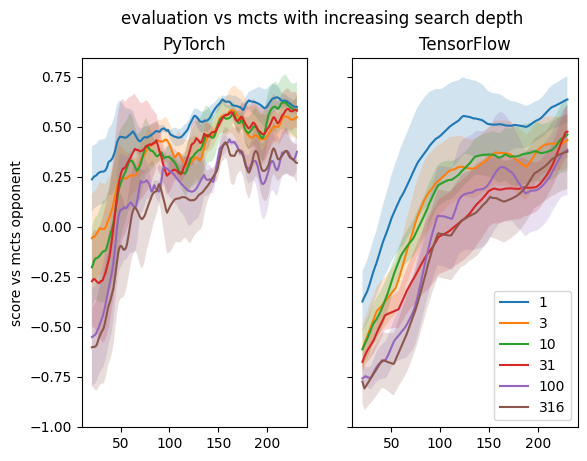

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title("PyTorch")
ax2.set_title("TensorFlow")

for c in cols:
    depth = int(10 ** (c / 2))
    med = np.nanmedian(combined['pt' + str(depth)], axis=0)
    std = np.nanstd(combined['pt' + str(depth)], axis=0)
    ax1.plot(df['step'].values[:250], med, label=depth)
    ax1.fill_between(
            df['step'].values[:250],
            med - std,
            med + std,
            alpha=0.2,
        )

for c in cols:
    depth = int(10 ** (c / 2))
    med = np.nanmedian(combined['tf' + str(depth)], axis=0)
    std = np.nanstd(combined['tf' + str(depth)], axis=0)
    ax2.plot(df['step'].values[:250], med, label=depth)
    ax2.fill_between(
            df['step'].values[:250],
            med - std,
            med + std,
            alpha=0.2,
        )

ax1.set_ylabel('score vs mcts opponent')

plt.suptitle('evaluation vs mcts with increasing search depth')
plt.legend()

In [12]:
path = os.path.join('..', 'az', 'pt', 'c4_4')
p2 = os.path.join('..', 'az', 'tf', 'c4_4')

In [13]:
with gfile.Open(os.path.join(path, "config.json")) as f:
    config = json.load(f)

with gfile.Open(os.path.join(p2, "config.json")) as f:
    config2 = json.load(f)

In [14]:
data = load_jsonl_data(os.path.join(path, "learner.jsonl"))
data2 = load_jsonl_data(os.path.join(p2, "learner.jsonl"))

In [15]:
print("config:")
print_columns(sorted("{}: {}".format(k, v) for k, v in config.items()))
print()
print("data keys:")
print_columns(sorted(data[0].keys()))
print()
print("training time:", datetime.timedelta(seconds=int(data[-1]["time_rel"])))
print("training steps: %d" % (data[-1]["step"]))
print("total states: %d" % (data[-1]["total_states"]))
print("total trajectories: %d" % (data[-1]["total_trajectories"]))
print()

config:
  alpha_puck: False         evaluators: 4           max_steps: 500    num_actors: 25                  policy_alpha: 1              temperature: 1.0          weight_decay: 0.0001  
  checkpoint_freq: 50       game: connect_four      nn_depth: 8       observation_shape: [3, 6, 7]    policy_epsilon: 0.25         temperature_drop: 10    
  eval_levels: 6            learning_rate: 0.001    nn_model: mlp     output_size: 7                  replay_buffer_reuse: 3       train_batch_size: 1024  
  evaluation_window: 100    max_simulations: 300    nn_width: 128     path: baseline2                 replay_buffer_size: 65536    uct_c: 2                

data keys:
  batch_size         eval                loss                          outcomes        states_per_s_actor    time_rel        total_trajectories    value_prediction  
  batch_size_hist    game_length         novelty_value                 queue_size      step                  time_str        trajectories_per_s  
  cache             

In [16]:
x = X_AXIS["step"]

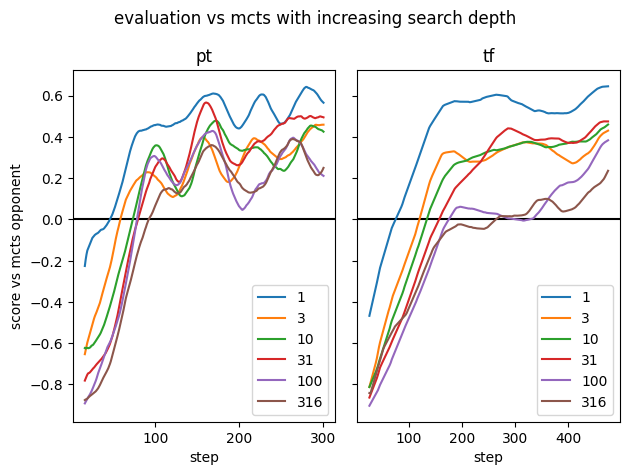

In [17]:
cols = list(range(len(data[0]["eval"]["results"])))
df = prepare(data, {int(10 ** (i / 2)): ["eval", "results", i] for i in cols})
df2 = prepare(data2, {int(10 ** (i / 2)): ["eval", "results", i] for i in cols})
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.axhline(y=0, color="black")
ax2.axhline(y=0, color="black")
for y in cols:
    df.plot(ax=ax1, x=x, y=int(10 ** (y / 2)))
    df2.plot(ax=ax2, x=x, y=int(10 ** (y / 2)))

ax1.set_title('pt')
ax2.set_title('tf')

ax1.set_ylabel('score vs mcts opponent')

plt.suptitle('evaluation vs mcts with increasing search depth')
plt.tight_layout()

In [196]:
from scipy.stats import mannwhitneyu

In [201]:
pt_outcomes = defaultdict(list)
tf_outcomes = defaultdict(list)
for c in cols:
    depth = int(10**(c/2))
    for exp in combined['pt' + str(depth)]:
        pt_outcomes[depth].append(exp[-1])
    for exp in combined['tf' + str(depth)]:
        tf_outcomes[depth].append(exp[-1])
        

for c in cols:
    depth = int(10**(c/2))
    print(f'pt vs tf {depth}: {mannwhitneyu(pt_outcomes[depth], tf_outcomes[depth])}')

pt vs tf 1: MannwhitneyuResult(statistic=6.0, pvalue=0.7642282177641773)
pt vs tf 3: MannwhitneyuResult(statistic=11.0, pvalue=0.3682271338216957)
pt vs tf 10: MannwhitneyuResult(statistic=11.0, pvalue=0.3682271338216957)
pt vs tf 31: MannwhitneyuResult(statistic=11.0, pvalue=0.3682271338216957)
pt vs tf 100: MannwhitneyuResult(statistic=6.0, pvalue=0.7642282177641773)
pt vs tf 316: MannwhitneyuResult(statistic=6.0, pvalue=0.7642282177641773)
